## This notebook queries various DAACs for sensor cadences of [Sentinel-1, Sentinel-2, and Landsat8] and saves them to a file
Inputs are area of interest (Polygon), date range (list of datetimes), and sampling resolution. Default sampling resolution is 1 degree longitude, 0.25 degree latitude.

In [2]:
from IPython.core.display import HTML
HTML("<style>.container { width:98% !important; }</style>")

In [3]:
%load_ext autoreload
%autoreload 2

In [2]:
# GIS imports
from shapely.geometry import Polygon, shape
from opera_coverage import *
import geopandas as gpd
import pandas as pd
from shapely.geometry import box, Point
from rasterio.crs import CRS

# Misc imports
import numpy as np
from itertools import product
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import concurrent.futures
from typing import List

In [3]:
output_path = Path('../output_dfs')
output_path.mkdir(exist_ok=True)

In [4]:
# helper functions
import sys
import time
# wrapper function for get_coverage, returns string if thread crashed while running
def get_cadence_df(geo:Polygon, daterange:List[datetime]):
    results = pd.DataFrame(columns=['center_x','center_y','startTime','geometry','sensor','fileID'])
    for k in range(3):
        try:
            df = get_coverage(['sentinel1','sentinel2','landsat8'], geo, daterange)
            df['cx'] = geo.centroid.x
            df['cy'] = geo.centroid.y
            return df
        except:
            print("Oops!", sys.exc_info()[0], "occurred.")
            print(f'thread crashed, attempt {k + 1}')
            time.sleep(2)
    return 'Thread crashed'

# the below two functions help grid the data into 1 degree by 1 degree boxes
def get_lat(geom):
    return int(np.floor(geom.centroid.coords.xy[1][0]))
def get_lon(geom):
    return int(np.floor(geom.centroid.coords.xy[0][0]))

# creates the 1 degree by 1 degree box
def make_box(row):
    return box(row['lon'], row['lat'], row['lon'] + 1, row['lat'] + 1)

For continent geometries use Natural Earth Lowres from Geopandas

In [10]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

pop_est      continent                      name iso_a3  gdp_md_est  \
0     889953.0        Oceania                      Fiji    FJI        5496   
1   58005463.0         Africa                  Tanzania    TZA       63177   
2     603253.0         Africa                 W. Sahara    ESH         907   
3   37589262.0  North America                    Canada    CAN     1736425   
4  328239523.0  North America  United States of America    USA    21433226   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [11]:
sorted(world.continent.unique())

['Africa',
 'Antarctica',
 'Asia',
 'Europe',
 'North America',
 'Oceania',
 'Seven seas (open ocean)',
 'South America']

In [12]:
def create_polygon(continent):
    df = world[world.continent == continent]
    return df.geometry.unary_union

In [13]:
polygon_dict = {key:value for key,value in zip(sorted(world.continent.unique()), list(map(create_polygon, sorted(world.continent.unique()))))}
del polygon_dict['Antarctica'],polygon_dict['Seven seas (open ocean)']

In [14]:
print(polygon_dict.keys())

dict_keys(['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'])


In [26]:
# main function, takes an area of interest as a polygon and a daterange as a list of two datetimes
# grid resolution can be changed from default values
def get_area_coverage(aoi: Polygon, date: List[datetime], x_res = 1, y_res = 0.25, radius = 0.1):

    df_points = grid_intersect(aoi, x_res, y_res, radius)
    results = lookup(df_points, date)
#     df_temp = regrid(results)
#     df_ag = aggregator(df_temp)
    
    return results

In [16]:
# creates an array of polygon circles within the rectangular bounds of the aoi, then takes intersection with the aoi, returns dataframe
def grid_intersect(aoi: Polygon, x_res, y_res, radius):
    
    x_start, y_start, x_end, y_end = aoi.bounds
    df = make_grid(x_start, y_start, x_end, y_end, x_res, y_res, radius)
    
    indices = df.geometry.intersects(aoi)
    
    return df[indices].reset_index(drop=True)

In [17]:
# for each geometry in dataframe, runs search through asf and hls search, reformats to dataframe
def lookup(df_points: gpd.GeoDataFrame, daterange) -> gpd.GeoDataFrame:
    results = []

    for i in range(len(df_points) // 200 + 1):
        with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
            results += list(executor.map(get_cadence_df, tqdm(df_points.geometry[(i * 200):(i + 1) * 200]), [daterange] * 200))
    
    results = pd.concat([i for i in results if type(i) is not str])
    results['cy'] = df_points.center_y
    results['cx'] = df_points.center_x
        
    return results

In [18]:
def calculate_averages(results):
    
    df_temp = df_points.copy()
    av_cad_hours = []
#     avail_sensors = []
    n_avail_sensors = []
    av_cad_hours += [i.cadence.mean().seconds/3600 if type(i) is not str else np.nan for i in results]
#     avail_sensors += [i.sensor.unique() if type(i) is not str else '' for i in results]
    n_avail_sensors += [len(i.sensor.unique()) if type(i) is not str else np.nan for i in results]
            
    df_temp['av_cad_hours'] = results.groupby(['cx','cy']).mean().reset_index(drop=True).cadence.seconds / 3600
#     df_temp['avail_sensors'] = avail_sensors
    df_temp['n_avail_sensors'] = n_avail_sensors
    
    return df_temp

In [19]:
# Re-grid results to 1x1 degree cells
def regrid(df_temp: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    
    df_temp['lon'] = df_temp.geometry.map(get_lon)
    df_temp['lat'] = df_temp.geometry.map(get_lat)
    
    return df_temp

# Use geodataframe groupby function to aggregate rows to 1 by 1 degree box
def aggregator(df_temp: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    df_ag = df_temp.groupby(['lon', 'lat']).mean().reset_index()
    geom = df_ag.apply(make_box, axis=1)
    df_ag = gpd.GeoDataFrame(df_ag,
                             geometry=geom,
                             crs = CRS.from_epsg(4326))
    return df_ag

In [20]:
# Make grid with specified x and y resolution, returns as geodataframe
def make_grid(x_start, y_start, x_end, y_end, x_res = 1, y_res = 0.25, radius = 0.1):
    lon_lat = list(product(
                np.linspace(x_start + (x_res/2), x_end - (x_res/2), int((x_end - x_start) / x_res)), 
                np.linspace(y_start + (y_res/2), y_end - (y_res/2), int((y_end - y_start) / y_res))
                ))

    geometry = [Point(lon, lat).buffer(radius) for lon, lat in lon_lat]

    center_x = [lon for lon, _ in lon_lat]
    center_y = [lat for _, lat in lon_lat]

    df = gpd.GeoDataFrame({'center_x':center_x, 'center_y':center_y}, geometry = geometry, crs=CRS.from_epsg(4326))
    
    return df

In [21]:
test_aoi = Polygon(([-119, 38],[-116,38],[-116, 40],[-119,40],[-119,38]))

In [22]:
df_points = grid_intersect(test_aoi, x_res = 1, y_res=1, radius = 0.1)
results = lookup(df_points, [datetime(2022,1,1),datetime(2022,2,1)])

100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 107.48it/s]


In [23]:
results.head()

startTime  \
0        2022-01-01 01:51:25+00:00   
1        2022-01-01 01:51:50+00:00   
2 2022-01-01 18:53:48.928000+00:00   
3 2022-01-05 18:33:33.912000+00:00   
4        2022-01-06 13:59:23+00:00   

                                            geometry     sensor  \
0  POLYGON ((-119.86262 38.34961, -119.46728 36.7...  sentinel1   
1  POLYGON ((-120.23078 39.84229, -119.82670 38.2...  sentinel1   
2  POLYGON ((-119.27282 37.83750, -118.02534 37.8...  sentinel2   
3  POLYGON ((-119.27282 37.83750, -118.02534 37.8...   landsat8   
4  POLYGON ((-117.45378 38.19339, -117.03466 39.8...  sentinel1   

                                              fileID                cadence  \
0  S1A_IW_SLC__1SDV_20220101T015125_20220101T0151...                    NaT   
1  S1A_IW_SLC__1SDV_20220101T015150_20220101T0152...        0 days 00:00:25   
2                 HLS.S30.T11SLC.2022001T184801.v2.0 0 days 17:01:58.928000   
3                 HLS.L30.T11SLC.2022005T183333.v2.0 3 days 23:39:44.984000   
4  S1A_IW_SLC__1SDV_20220106T135923_20220106T1359... 0 days 19:25:49.088000   

      cx    cy  
0 -118.5  38.5  
1 -118.5  39.5  
2 -117.5  38.5  
3 -117.5  39.5  
4 -116.5  38.5

In [24]:
results.to_pickle(output_path/'results.pkl')

In [27]:
for key,value in polygon_dict.items():
    df = get_area_coverage(value, [datetime(2022,1,1),datetime(2022,2,1)], x_res = 1, y_res = 1, radius = 0.1)
    df.to_pickle(output_path/f"{key}_results.pkl")

100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7640.25it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6713.68it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataf

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Se

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6185.19it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty!

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7079.59it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5612.80it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Se

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataf

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6339.30it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7794.58it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataf

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8485.00it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: U

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty!

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataf

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 9584.46it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashedThread crashed
Thread crashed
Thread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dat

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 datafr

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: U

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8113.24it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).r

/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32:

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWar

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWar

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Land

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWar

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: U

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/forma

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7355.65it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/forma

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWar

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWar

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8016.02it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 datafr

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Se

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/forma

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: U

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dat

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed
Thread crashed
Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3206.10it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: U

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Se

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 datafr

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Se

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataf

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dat

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty!

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashedThread crashed
Thread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 4018.49it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataf

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty!

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataf

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Se

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataf

Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty!

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataf

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2856.05it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 d

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dat

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty!

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 d

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWar

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty!

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Se

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7033.82it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dat

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty!

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 d

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty!

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3333.67it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashedThread crashed

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashedThread crashed

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataf

Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 11914.79it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataf

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashedThread crashed



100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3133.22it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dat

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1653.44it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dat

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: 

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dat

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dat

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7847.45it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dat

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty!

Thread crashedThread crashed
Thread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8942.22it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 d

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataf

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 10317.20it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty!

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7335.97it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTim

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: U

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6987.65it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTim

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Se

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWar

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWar

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dat

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: U

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dat

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63:

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Land

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashedThread crashed
Thread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dat

Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dat

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7264.25it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTim

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Land

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dat

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning

/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning

/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Land

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dat

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataf

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/forma

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Land

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 11428.00it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning

Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6757.21it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).res

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWar

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dat

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Land

/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashedThread crashed
Thread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Land

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataf

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3471.50it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Use

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWar

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dat

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty!

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dat

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty!

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dat

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty!

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dat

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashedThread crashed

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empt

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dat

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7808.80it

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dat

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: 

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 4955.02it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Land

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6043.80it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).r

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32:

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty!

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWar

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWar

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 data

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe i

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dat

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty!

Thread crashedThread crashed
Thread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Land

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dat

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWar

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Land

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6685.91it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['st

/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWar

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataf

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6833.62it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).r

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning

/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63:

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWar

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empt

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 da

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentin

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWar

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserW

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 2126.99it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTim

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Se

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Land

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Land

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  df = df.sort_values(by=['startTime']).reset_index(drop=True)
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:63:

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataf

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/forma

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataf

Thread crashed


100%|████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 8565.88it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 9021.08it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty!

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataf

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty!

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Se

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 datafr

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty!

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6232.90it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check 

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:65: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  df = df.reindex(columns=['startTime','geometry','sensor','fileID'])
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataf

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

In [142]:
df_points.head()

center_x  center_y                                           geometry
0    -118.5      38.5  POLYGON ((-118.40000 38.50000, -118.40048 38.4...
1    -118.5      39.5  POLYGON ((-118.40000 39.50000, -118.40048 39.4...
2    -117.5      38.5  POLYGON ((-117.40000 38.50000, -117.40048 38.4...
3    -117.5      39.5  POLYGON ((-117.40000 39.50000, -117.40048 39.4...
4    -116.5      38.5  POLYGON ((-116.40000 38.50000, -116.40048 38.4...

In [21]:
%%time
df = get_area_coverage(australia_geo,[datetime(2022,1,1),datetime(2022,2,1)],y_res = 1)

100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 4637.87it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


100%|██████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 2889.32it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

CPU times: user 2min 10s, sys: 34.2 s, total: 2min 44s
Wall time: 7min 13s


In [22]:
df

lon  lat    center_x   center_y  av_cad_hours  n_avail_sensors  \
0    113  -27  113.838953 -26.635804     21.298056              2.0   
1    113  -25  113.838953 -24.573455      3.428333              2.0   
2    113  -24  113.838953 -23.542281      3.428333              2.0   
3    113  -23  113.838953 -22.511106     23.999722              2.0   
4    114  -29  114.844864 -28.698153     19.188889              2.0   
..   ...  ...         ...        ...           ...              ...   
683  153  -30  153.069469 -29.729328     15.709167              3.0   
684  153  -29  153.069469 -28.698153     10.400278              3.0   
685  153  -28  153.069469 -27.666979      9.371667              3.0   
686  153  -27  153.069469 -26.635804     22.273611              3.0   
687  153  -26  153.069469 -25.604630      8.953333              3.0   

                                              geometry  
0    POLYGON ((114.00000 -27.00000, 114.00000 -26.0...  
1    POLYGON ((114.00000 -25.00000, 114.00000 -24.0...  
2    POLYGON ((114.00000 -24.00000, 114.00000 -23.0...  
3    POLYGON ((114.00000 -23.00000, 114.00000 -22.0...  
4    POLYGON ((115.00000 -29.00000, 115.00000 -28.0...  
..                                                 ...  
683  POLYGON ((154.00000 -30.00000, 154.00000 -29.0...  
684  POLYGON ((154.00000 -29.00000, 154.00000 -28.0...  
685  POLYGON ((154.00000 -28.00000, 154.00000 -27.0...  
686  POLYGON ((154.00000 -27.00000, 154.00000 -26.0...  
687  POLYGON ((154.00000 -26.00000, 154.00000 -25.0...  

[688 rows x 7 columns]

In [23]:
df.to_file('Australia 687')

/var/folders/hs/wfv_gwl12y740vc3gk80q82h0000gq/T/ipykernel_8621/2835263052.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file('Australia 687')


In [80]:
%%time
df = get_area_coverage(europe_geo,[datetime(2022,1,1),datetime(2022,2,1)],y_res = 1)
beepy.beep(sound=5)

100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8328.15it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1730.85it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn(

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8258.70it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8236.16it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn(

Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3142.58it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5362.94it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6045.93it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2646.59it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashedThread crashed

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashedThread crashed

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5532.65it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5214.46it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashedThread crashed

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 11306.01it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7201.57it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1352.68it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashedThread crashed
Thread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5818.31it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn(

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn(

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed
Thread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


CPU times: user 10min 25s, sys: 1min 42s, total: 12min 7s
Wall time: 45min 5s


In [82]:
len(df)

3868

In [27]:
df.to_file('Europe 3868')

/var/folders/hs/wfv_gwl12y740vc3gk80q82h0000gq/T/ipykernel_8621/4205959376.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file('Europe 3868')


In [32]:
import beepy
beepy.beep(sound=5)

In [34]:
%%time
df1 = get_area_coverage(northamerica_geo,[datetime(2022,1,1),datetime(2022,2,1)],y_res = 1)
beepy.beep(sound=5)

100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 9568.50it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn(

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3401.13it/s]


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed
Thread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3911.99it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6814.02it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8598.06it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 10531.18it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6796.03it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_cov

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn(

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5279.54it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn(

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 3908.21it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_c

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  war

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  w

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashedThread crashed



/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:59: UserWarning: Sentinel-2 dataframe is empty! Check inputs.
  warn('Sentinel-2 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

Thread crashed
CPU times: user 10min 53s, sys: 2min 25s, total: 13min 18s
Wall time: 36min 17s


In [35]:
len(df1)

3854

In [36]:
df1.to_file('N Amer 3854')

/var/folders/hs/wfv_gwl12y740vc3gk80q82h0000gq/T/ipykernel_8621/2280291351.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df1.to_file('N Amer 3854')


In [38]:
%%time
df2 = get_area_coverage(southamerica_geo,[datetime(2022,1,1),datetime(2022,2,1)],y_res = 1)
beepy.beep(sound=5)

100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6939.56it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 11541.84it/s]
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 9928.52it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


100%|█████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 886.37it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 10330.03it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_c

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7519.57it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn(

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

CPU times: user 5min 5s, sys: 1min, total: 6min 6s
Wall time: 16min 15s


In [39]:
len(df2)

1551

In [40]:
df2.to_file('S Amer 1551')

/var/folders/hs/wfv_gwl12y740vc3gk80q82h0000gq/T/ipykernel_8621/3889617379.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df2.to_file('S Amer 1551')


In [43]:
%%time
df3 = get_area_coverage(africa_geo,[datetime(2022,1,1),datetime(2022,2,1)],y_res = 1)
beepy.beep(sound=5)

100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 9735.18it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 9813.07it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8883.79it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 11613.74it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 9823.30it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6110.23it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7941.50it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashedThread crashed
Thread crashed

Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashedThread crashed

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

KeyboardInterrupt: 

In [44]:
len(df3)

2557

In [45]:
df3.to_file('Africa 2557')

/var/folders/hs/wfv_gwl12y740vc3gk80q82h0000gq/T/ipykernel_8621/246746214.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df3.to_file('Africa 2557')


In [46]:
df4 = get_area_coverage(asia_geo,[datetime(2022,1,1),datetime(2022,2,1)],y_res = 1)

100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8378.39it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  w

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  wa

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6713.20it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_c

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6276.88it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6307.56it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3718.24it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_cov

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  war

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 10343.79it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

Thread crashed
Thread crashed
Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed


/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')


Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed
Thread crashed


In [48]:
len(df4)

3107

In [49]:
df4.to_file('Asia 3107')

/var/folders/hs/wfv_gwl12y740vc3gk80q82h0000gq/T/ipykernel_8621/1228760143.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df4.to_file('Asia 3107')


In [52]:
df5 = get_area_coverage(oceania_geo,[datetime(2022,1,1),datetime(2022,2,1)],y_res = 1)
beepy.beep(sound=5)

100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1998.34it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
 

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.

/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:61: UserWarning: Landsat-8 dataframe is empty! Check inputs.
  warn('Landsat-8 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn(

Thread crashed


100%|████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 5699.35it/s]
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/opera_coverage/opera_coverage/formatting.py:32: UserWarning: Sentinel-1 dataframe is empty! Check inputs.
  warn('Sentinel-1 dataframe is empty! Check inputs.')
/Users/angelac/ope

AttributeError: 'NoneType' object has no attribute 'bounds'

In [55]:
len(df5)

790

In [56]:
df5.to_file('Oceania 790')

/var/folders/hs/wfv_gwl12y740vc3gk80q82h0000gq/T/ipykernel_8621/1249661340.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df5.to_file('Oceania 790')


Text(0.5, 1.0, 'Global Coverage Cadence in Hours')

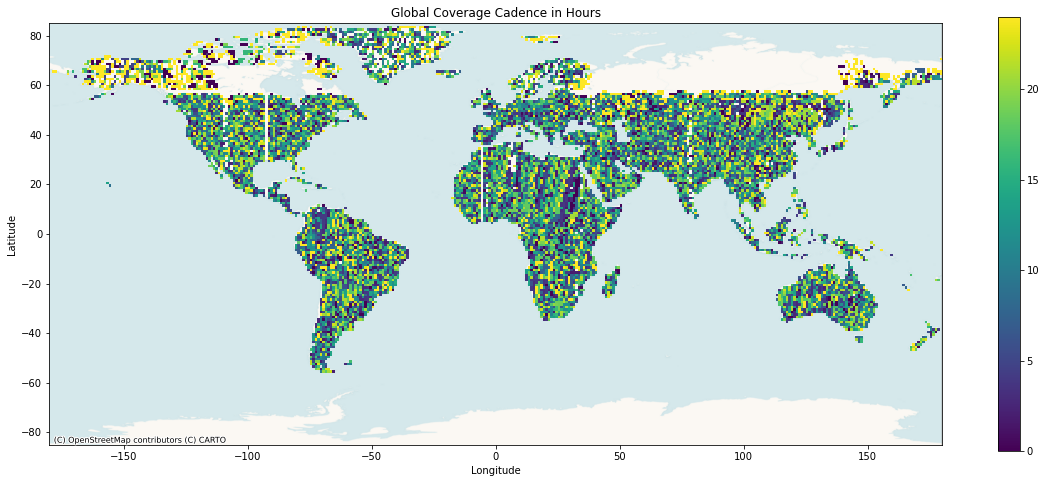

In [128]:
import matplotlib.pyplot as plt
import contextily as cx
from rasterio.crs import CRS

fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlim(-180,180)
ax.set_ylim(-85,85)
europe_plot = df_europe_test.plot(column='av_cad_hours', ax=ax, legend=True)
df1.plot(column='av_cad_hours', ax = ax)
df2.plot(column='av_cad_hours', ax = ax)
df3.plot(column='av_cad_hours', ax = ax)
df4.plot(column='av_cad_hours', ax = ax)
df5.plot(column='av_cad_hours', ax = ax)
cx.add_basemap(ax=ax,crs='EPSG:4326',source=cx.providers.CartoDB.VoyagerNoLabels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Global Coverage Cadence in Hours')

In [107]:
import rasterio
bounds_4326 = np.array([-180, -85, 180, 85])
bounds_3857 = rasterio.warp.transform_bounds(CRS.from_epsg(4326),
                                             CRS.from_epsg(3857),
                                             *bounds_4326)

In [112]:
X, extent = cx.bounds2raster(*bounds_3857, 
                              '/Users/angelac/opera_coverage/notebooks/world.tiff',
                              source=cx.providers.CartoDB.VoyagerNoLabels)

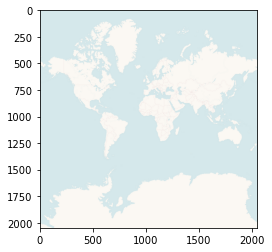

In [117]:
plt.imshow(X)